# Cause of underestimated active units

author: steeve.laquitaine@epfl.ch

TODO:
- check source code to detect overmerging

Setup environment: 

```bash
pip install requirements_kilosort_silico
```

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import bisect
import spikeinterface as si

proj_path = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting"
os.chdir(proj_path)

from src.nodes.utils import get_config
from src.nodes.postpro.cell_matching import get_SpikeInterface_matching_object, match_sorted_to_true_neuropixels_2023_02_19
from src.nodes.postpro.feateng import (add_firing_rates)
from src.nodes.postpro.cell_matching import get_missed_units, get_detected_units

# SET PARAMETERS
EXPERIMENT = "silico_neuropixels"
SIMULATION_DATE = "2023_02_19"
MATCH_WIND_MS = 0.4
SAMPLING_FREQ = 10000 # sample/sec

# GET RUN CONFIG
data_conf, param_conf = get_config(EXPERIMENT, SIMULATION_DATE).values()

CELL_MATCHING_PATH = data_conf["postprocessing"]["cell_matching"]

LOW_RATE_CEILING = 0.2  # max firing rate where negative proba change is observed in "bias plot"
MID_RATE_CEILING = 1    # max firing rate where positive proba change is observed in "bias plot"

# set Kilosort sorted spikes and cells path
KS3_SORTING_PATH = data_conf["sorting"]["sorters"]["kilosort3"]["output"]

# set ground truth spikes and cells path
GT_SORTING_PATH = data_conf["sorting"]["simulation"]["ground_truth"]["output"]

2023-06-03 19:02:53,242 - root - utils.py - get_config - INFO - Reading experiment config.
2023-06-03 19:02:53,328 - root - utils.py - get_config - INFO - Reading experiment config. - done
2023-06-03 19:02:53,330 - root - utils.py - get_config - INFO - Reading experiment config.
2023-06-03 19:02:53,354 - root - utils.py - get_config - INFO - Reading experiment config. - done


In [2]:
# get matching object
MatchingObject = get_SpikeInterface_matching_object(GT_SORTING_PATH, KS3_SORTING_PATH)

In [3]:
# get matching dataframe
match = match_sorted_to_true_neuropixels_2023_02_19(GT_SORTING_PATH, KS3_SORTING_PATH)

/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/src/nodes/postpro/cell_matching.py:235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_matching["oversplit"][
/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/src/nodes/postpro/cell_matching.py:249: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_matching["missed"][cell_matching["true_unit"].isin(missed)] = True


In [42]:
# add firing rate
matching = match["cell_matching"]
matching = add_firing_rates(matching, GT_SORTING_PATH, KS3_SORTING_PATH, data_conf)

In [10]:
# get missed units
missed_units = get_missed_units(MatchingObject.agreement_scores)
missed_data = matching[matching["true_unit"].isin(missed_units)]

# get detected units
detected_units = get_detected_units(MatchingObject.agreement_scores)
detected_data = matching[matching["true_unit"].isin(detected_units)]

In [43]:
# find detected active cells (above 1Hz) that were underestimated
df = matching.dropna(subset="true_unit")
active_units = df.loc[df["true firing rate"] > MID_RATE_CEILING, "true_unit"].tolist()
under_units = df.loc[df["true firing rate"] < df["ks3 firing rate"], "true_unit"].tolist()
under_active_units = set(active_units) - set(under_units)

# get the matching data
matching = df[df["true_unit"].isin(under_active_units)]
matching

,true_unit,sorted_unit,oversplit,missed,true firing rate,ks3 firing rate
118,4216128.0,141.0,True,False,1.876401,1.549122
123,4064376.0,166.0,True,False,1.732762,1.701852
147,505734.0,297.0,True,False,1.640033,0.981838
165,2332583.0,287.0,True,False,1.450938,0.309097
189,1864097.0,33.0,True,False,2.845511,1.981858
231,2203846.0,24.0,True,False,1.694579,0.367280
242,1721410.0,17.0,True,False,3.100062,2.481868
262,3783050.0,129.0,True,False,1.787308,0.901836
268,3480638.0,88.0,True,False,1.349118,0.878199
273,4138989.0,216.0,True,False,2.105497,0.194549


In [13]:
# get the sorted units associated with the sparse true units
match = match_sorted_to_true_neuropixels_2023_02_19(GT_SORTING_PATH, KS3_SORTING_PATH)

/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/src/nodes/postpro/cell_matching.py:235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_matching["oversplit"][
/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/src/nodes/postpro/cell_matching.py:249: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_matching["missed"][cell_matching["true_unit"].isin(missed)] = True


In [15]:
# are the sorted units overmerged (have non zero agreement scores with other true units)
# get matching object
Matching = get_SpikeInterface_matching_object(GT_SORTING_PATH, KS3_SORTING_PATH)

## Oversplitting hypothesis: true units are split between several sorted units


In [56]:
target_true_units = matching["true_unit"].tolist()

not_null_count = (Matching.agreement_scores.loc[target_true_units,:] > 0).sum(axis=1)

# count 
n_total = len(not_null_count)
n_oversplit = sum(not_null_count > 1)
n_not_oversplit = n_total - n_oversplit
percent_oversplit = n_oversplit/n_total*100
percent_not_oversplit = n_not_oversplit/n_total*100

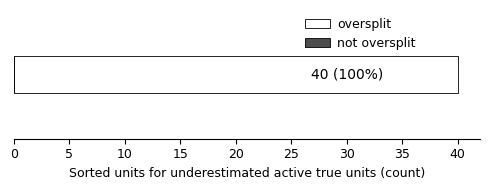

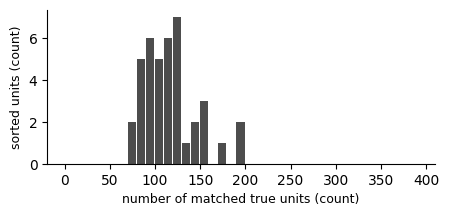

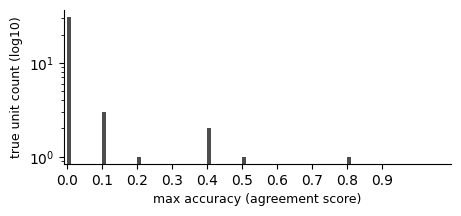

In [57]:
from matplotlib import pyplot as plt

# build histo dataset
data_df = pd.DataFrame(
    {
        "cell count": [
            n_oversplit,
            n_not_oversplit,
        ],
    },
    index=["oversplit", "not oversplit"],
)

# set figure
fig, axis = plt.subplots(1, 1, figsize=(5, 2))

# set plot legend
colors = ["w", [0.3, 0.3, 0.3]]
txt_colors = ["k", "w"]
percents = [percent_oversplit, percent_not_oversplit]

# plot
ax = data_df.T.plot.barh(
    ax=axis,
    stacked=True,
    color=colors,
    width=0.2,
    edgecolor="k",
    linewidth=0.6,
)

# set axis legend
ax.spines[["left", "right", "top"]].set_visible(False)
x_axis = ax.axes.get_xaxis()
x_axis.set_visible(True)
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)
ax.set_xlabel("Sorted units for underestimated active true units (count)", fontsize=9)
ax.legend(
    bbox_to_anchor=(0.6, 0.6),
    frameon=False,
    fontsize=9,
    handletextpad=0.6,
)
# ax.set_title("Overmerging explains sparse unit overestimated FR", fontsize=9)
ax.tick_params(axis="both", which="major", labelsize=9)
plt.tight_layout()

# annotate bars with count by sorting error type
x_shift = 10
for p_i, patch in enumerate(ax.patches):
    width, height = patch.get_width(), patch.get_height()
    x, y = patch.get_xy()
    if not width==0:
        ax.text(
            x + width / 2 + x_shift,
            y + height / 2,
            "{:.0f} ({:.0f}%)".format(width, percents[p_i]),
            horizontalalignment="center",
            verticalalignment="center",
            color=txt_colors[p_i],
        )
    
# set firing rate bins
fig, ax = plt.subplots(figsize=(5,2))
bin_width = 9

BINS = np.arange(0, 400, 10)

ax = not_null_count.hist(bins=BINS, width=bin_width, color=[0.3, 0.3, 0.3]);

# legend
ax.set_xlabel("number of matched true units (count)", fontsize=9)
ax.set_ylabel("sorted units (count)", fontsize=9)
ax.grid(False)
ax.spines[["right", "top"]].set_visible(False)

# plot agreement scores
target_units = matching["true_unit"].astype(int).tolist()
scores = MatchingObject.agreement_scores.loc[target_units,:]
accuracy = scores.max(axis=1)

# set firing rate bins
fig, ax = plt.subplots(figsize=(5,2))

# set plot params
bin_width = 0.01
BINS = np.arange(0, 1, 0.1)

# plot
ax = accuracy.hist(bins=BINS, width=bin_width, color=[0.3, 0.3, 0.3]);

# legend
ax.set_xlabel("max accuracy (agreement score)", fontsize=9)
ax.set_ylabel("true unit count (log10)", fontsize=9)
ax.set_xticks(BINS)

ax.grid(False)
ax.spines[["right", "top"]].set_visible(False)
ax.set_yscale('log')
ax.set_xlim([-0.01, accuracy.max()+0.1]);

## Overmerging hypothesis: Spurious spikes from other units explain overestimation


In [59]:
# get the sorted unit ids
sorted_u = matching["sorted_unit"].unique()

# get sorted units scores with true units
sorted_u_score = Matching.agreement_scores.loc[:, sorted_u]
not_null_count = (sorted_u_score > 0).sum(axis=0)

# count overmerged or not
n_total = len(sorted_u)
n_overmerged = sum(not_null_count > 1)
n_not_overmerged = n_total - n_overmerged

percent_overmerged = n_overmerged/n_total*100
percent_not_overmerged = n_not_overmerged/n_total*100

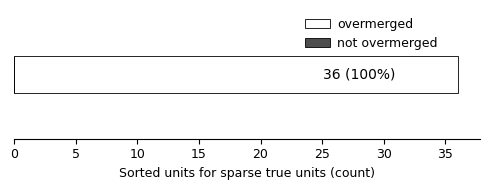

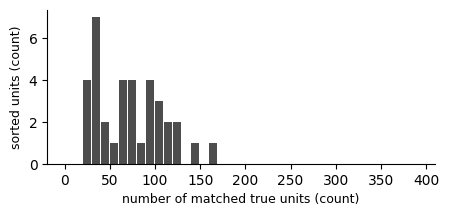

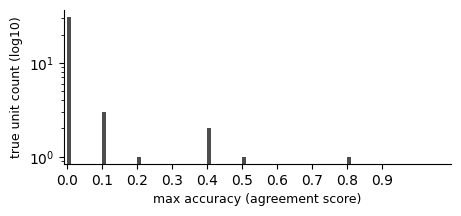

In [60]:
from matplotlib import pyplot as plt

# build histo dataset
data_df = pd.DataFrame(
    {
        "cell count": [
            n_overmerged,
            n_not_overmerged,
        ],
    },
    index=["overmerged", "not overmerged"],
)

# set figure
fig, axis = plt.subplots(1, 1, figsize=(5, 2))

# set plot legend
colors = ["w", [0.3, 0.3, 0.3]]
txt_colors = ["k", "w"]
percents = [percent_overmerged, percent_not_overmerged]

# plot
ax = data_df.T.plot.barh(
    ax=axis,
    stacked=True,
    color=colors,
    width=0.2,
    edgecolor="k",
    linewidth=0.6,
)

# set axis legend
ax.spines[["left", "right", "top"]].set_visible(False)
x_axis = ax.axes.get_xaxis()
x_axis.set_visible(True)
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)
ax.set_xlabel("Sorted units for sparse true units (count)", fontsize=9)
ax.legend(
    bbox_to_anchor=(0.6, 0.6),
    frameon=False,
    fontsize=9,
    handletextpad=0.6,
)
# ax.set_title("Overmerging explains sparse unit overestimated FR", fontsize=9)
ax.tick_params(axis="both", which="major", labelsize=9)
plt.tight_layout()

# annotate bars with count by sorting error type
x_shift = 10
for p_i, patch in enumerate(ax.patches):
    width, height = patch.get_width(), patch.get_height()
    x, y = patch.get_xy()
    if not width==0:
        ax.text(
            x + width / 2 + x_shift,
            y + height / 2,
            "{:.0f} ({:.0f}%)".format(width, percents[p_i]),
            horizontalalignment="center",
            verticalalignment="center",
            color=txt_colors[p_i],
        )
    
# set firing rate bins
fig, ax = plt.subplots(figsize=(5,2))
bin_width = 9

BINS = np.arange(0, 400, 10)

ax = not_null_count.hist(bins=BINS, width=bin_width, color=[0.3, 0.3, 0.3]);

# legend
ax.set_xlabel("number of matched true units (count)", fontsize=9)
ax.set_ylabel("sorted units (count)", fontsize=9)
ax.grid(False)
ax.spines[["right", "top"]].set_visible(False)

# plot agreement scores
target_units = matching["true_unit"].astype(int).tolist()
scores = MatchingObject.agreement_scores.loc[target_units,:]
accuracy = scores.max(axis=1)

# set firing rate bins
fig, ax = plt.subplots(figsize=(5,2))

# set plot params
bin_width = 0.01
BINS = np.arange(0, 1, 0.1)

# plot
ax = accuracy.hist(bins=BINS, width=bin_width, color=[0.3, 0.3, 0.3]);

# legend
ax.set_xlabel("max accuracy (agreement score)", fontsize=9)
ax.set_ylabel("true unit count (log10)", fontsize=9)
ax.set_xticks(BINS)

ax.grid(False)
ax.spines[["right", "top"]].set_visible(False)
ax.set_yscale('log')
ax.set_xlim([-0.01, accuracy.max()+0.1]);

In [35]:
print("overestimated active units (total count):", matching.shape[0])

overestimated active units (total count): 40


## Noise hypothesis.


In [36]:
def count_noise_ttp(sorted_ttps, true_ttps, match_wind:int=4):
    """count noise signals in a sorted units' spike train
    A noise signal is a signal that matches no timestamp
    from any true units (within match_wind)

    Args:
        sorted_ttps (_type_): _description_
        true_ttps (_type_): _description_

    Returns:
        _type_: _description_
    """
    # Create a NumPy array from array2
    array2 = np.array(true_ttps)
    array1 = np.array(sorted_ttps)

    # Check if any value in array1 is within a distance of match_wind from array2
    mask = np.any(np.abs(array1[:, np.newaxis] - array2) <= match_wind, axis=1)

    # Count the number of values in array1 that are not within the desired distance
    count = np.sum(~mask)
    return count

In [55]:
print(len(sorted_units))

26


In [38]:
# convert (0.4 ms in SpikeInterface) matching window to timepoints
match_wind = int(MATCH_WIND_MS * SAMPLING_FREQ / 1000)

# get the near-contact true units ids
true_units_ids = match["cell_matching"]["true_unit"].tolist()

# get the timestamps of sorted units matched to detected active underestimated true units 
Sorting = si.load_extractor(KS3_SORTING_PATH)

# get the true units spike timestamps
Truth = si.load_extractor(GT_SORTING_PATH)

# get all true unit timestamps
true_ttps = []
for unit_i in true_units_ids:
    true_ttps += Truth.get_unit_spike_train(unit_i).tolist()

# count the noise timestamps for a sorted unit (LOOPING OVER ALL UNITS TOO SLOW)
noise_ratios = []
noise_counts = []
for sorted_i in sorted_u:
    sorted_ttps = Sorting.get_unit_spike_train(unit_id=sorted_i)
    noise_count = count_noise_ttp(sorted_ttps, true_ttps, match_wind)
    noise_counts.append(noise_count)
    noise_ratios.append(noise_count/len(sorted_ttps))

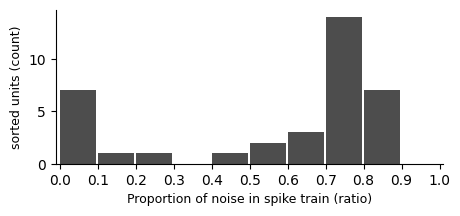

In [39]:
# plot
bins = np.arange(0,1.1,0.1)
fig, ax = plt.subplots(figsize=(5,2))
ax.hist(noise_ratios, bins=bins, width=0.095, color=(0.3, 0.3, 0.3));
ax.set_xticks(bins)
ax.set_xlim([-0.01, 1.01]);
ax.set_xlabel("Proportion of noise in spike train (ratio)", fontsize=9)
ax.set_ylabel("sorted units (count)", fontsize=9)
ax.grid(False)
ax.spines[["right", "top"]].set_visible(False)

In [69]:
print(sum(np.array(noise_ratios) > 0) / len(noise_ratios)*100, "% of sorted units contained noise")
print("Sorted units with more than 50% noise (ratio):", sum(np.array(noise_ratios) > 0.5)/len(noise_ratios))

97.22222222222221 % of sorted units contained noise
Sorted units with more than 50% noise (ratio): 0.7222222222222222
